In [1]:
# pip install xgboost

In [2]:
# pip install keras 

In [68]:
# pip install tensorflow

In [69]:
# pip install pytorch-tabnet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [158]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pytorch_tabnet
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from pytorch_tabnet.tab_model import TabNetClassifier

In [5]:
data = pd.read_csv('csgo_round_snapshots.csv')

In [6]:
data.shape

(122410, 97)

In [7]:
data

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [9]:
data.isnull().sum()

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64

In [10]:
types=['object' , 'bool']
categorical_columns=list(data.select_dtypes(include=types).columns)

In [11]:
'''
fig, ax = plt.subplots(3,1, figsize = (15,20))

ax = np.ravel(ax)
for i in range(len(categorical_columns)):
    sns.countplot(data = data, x = categorical_columns[i], ax = ax[i], palette="magma", order = data[categorical_columns[i]].value_counts().index)
    ax[i].set_xticklabels(labels = data[categorical_columns[i]].unique(), ha='right')
ax = np.reshape(ax, (3, 1))
plt.tight_layout()
'''

'\nfig, ax = plt.subplots(3,1, figsize = (15,20))\n\nax = np.ravel(ax)\nfor i in range(len(categorical_columns)):\n    sns.countplot(data = data, x = categorical_columns[i], ax = ax[i], palette="magma", order = data[categorical_columns[i]].value_counts().index)\n    ax[i].set_xticklabels(labels = data[categorical_columns[i]].unique(), ha=\'right\')\nax = np.reshape(ax, (3, 1))\nplt.tight_layout()\n'

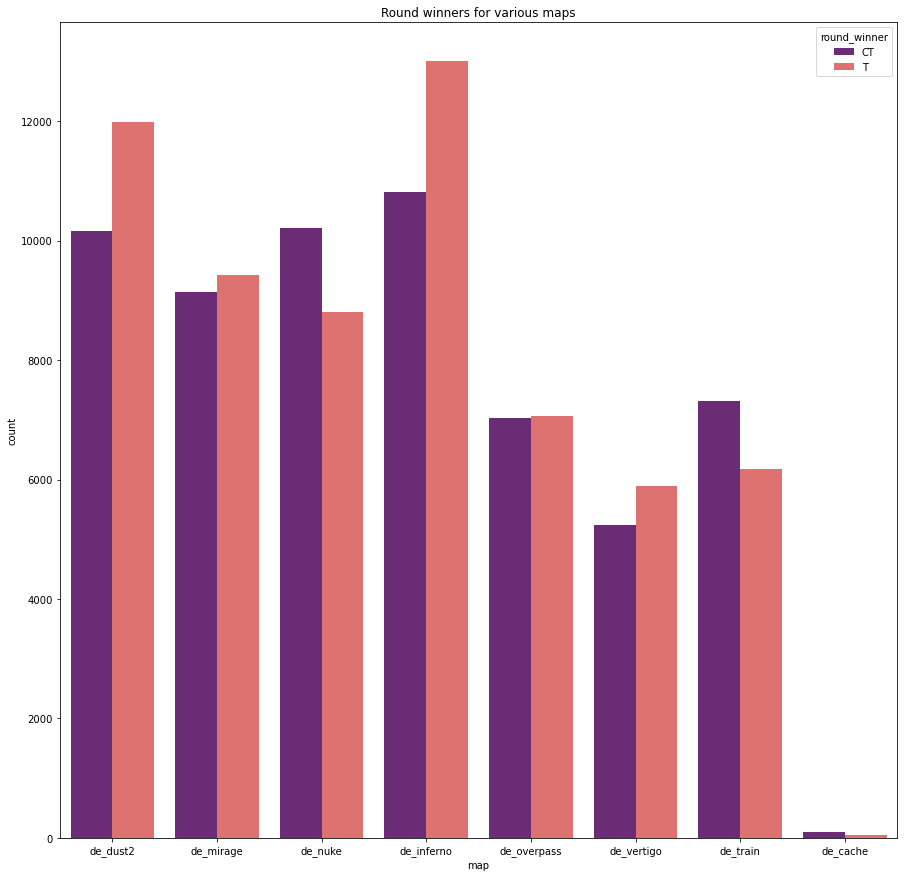

In [12]:
plt.figure(figsize=(15,15))
ax = sns.countplot(x="map", hue="round_winner", data=data, palette='magma')
ax.set(title='Round winners for various maps')
plt.show()

In [13]:
'''
numCols = data.select_dtypes([np.number]).columns

for col in numCols:
    plt.figure(figsize=(18,6))
    sns.displot(x=col,data=data, palette="magma")
    plt.show()
    '''

'\nnumCols = data.select_dtypes([np.number]).columns\n\nfor col in numCols:\n    plt.figure(figsize=(18,6))\n    sns.displot(x=col,data=data, palette="magma")\n    plt.show()\n    '

In [14]:
'''
weapons = ['ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
           'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
           'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
           't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
           'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
           't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
           'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
           'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
           'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
           'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
           'ct_weapon_negev', 't_weapon_negev', 'ct_weapon_nova', 't_weapon_nova',
           'ct_weapon_p90', 't_weapon_p90', 'ct_weapon_r8revolver',
           't_weapon_r8revolver', 'ct_weapon_sawedoff', 't_weapon_sawedoff',
           'ct_weapon_scar20', 't_weapon_scar20', 'ct_weapon_sg553',
           't_weapon_sg553', 'ct_weapon_ssg08', 't_weapon_ssg08',
           'ct_weapon_ump45', 't_weapon_ump45', 'ct_weapon_xm1014',
           't_weapon_xm1014', 'ct_weapon_deagle', 't_weapon_deagle',
           'ct_weapon_fiveseven', 't_weapon_fiveseven', 'ct_weapon_usps',
           't_weapon_usps', 'ct_weapon_p250', 't_weapon_p250', 'ct_weapon_p2000',
           't_weapon_p2000', 'ct_weapon_tec9', 't_weapon_tec9',
           'ct_grenade_hegrenade', 't_grenade_hegrenade', 'ct_grenade_flashbang',
           't_grenade_flashbang', 'ct_grenade_smokegrenade',
           't_grenade_smokegrenade', 'ct_grenade_incendiarygrenade',
           't_grenade_incendiarygrenade', 'ct_grenade_molotovgrenade',
           't_grenade_molotovgrenade', 'ct_grenade_decoygrenade',
           't_grenade_decoygrenade']

nums = [0]*len(weapons)
'''

"\nweapons = ['ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',\n           'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',\n           'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',\n           't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',\n           'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',\n           't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',\n           'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',\n           'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',\n           'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',\n           'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',\n           'ct_weapon_negev', 't_weapon_negev', 'ct_weapon_nova', 't_weapon_nova',\n           'ct_weapon_p90', 't_weapon_p90', 'ct_weapon_r8revolver',\n           't_weapon_r8revolver', 'ct_weapon_sawedoff', 't_weapon_sawedo

In [15]:
'''
for i in range(0, len(weapons)):
    nums[weapons.index(weapons[i])] = sum(data[weapons[i]])
   
for i in range(0, len(weapons)):
    weapons[i] = [weapons[i], nums[i]]
    
weapons.sort(key=lambda xx: xx[1], reverse=False)

x = []
y = []

for i in range(0, len(weapons)):
    x.append(weapons[i][0])
    y.append(weapons[i][1])
    '''

'\nfor i in range(0, len(weapons)):\n    nums[weapons.index(weapons[i])] = sum(data[weapons[i]])\n   \nfor i in range(0, len(weapons)):\n    weapons[i] = [weapons[i], nums[i]]\n    \nweapons.sort(key=lambda xx: xx[1], reverse=False)\n\nx = []\ny = []\n\nfor i in range(0, len(weapons)):\n    x.append(weapons[i][0])\n    y.append(weapons[i][1])\n    '

In [16]:
'''
plt.rcParams["figure.figsize"] = (12, 32)
plt.rcParams["font.size"] = 18
plt.title("Popular weapons.")
plt.grid(linestyle="--")
plt.xticks(rotation=61)
plt.plot(y, x, linewidth=2.61, marker="o")
plt.show()    '''

'\nplt.rcParams["figure.figsize"] = (12, 32)\nplt.rcParams["font.size"] = 18\nplt.title("Popular weapons.")\nplt.grid(linestyle="--")\nplt.xticks(rotation=61)\nplt.plot(y, x, linewidth=2.61, marker="o")\nplt.show()    '

In [17]:
round_winner=data['round_winner']

In [18]:
round_winner.describe()

count     122410
unique         2
top            T
freq       62406
Name: round_winner, dtype: object

In [19]:
round_winner.value_counts()

T     62406
CT    60004
Name: round_winner, dtype: int64

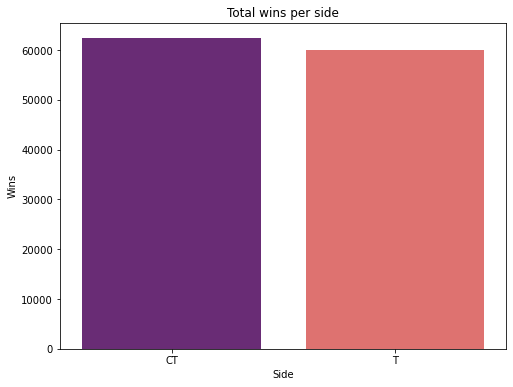

In [20]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x=data['round_winner'].unique(), y=data['round_winner'].value_counts() , palette='magma')
ax.set(title='Total wins per side', xlabel='Side', ylabel='Wins')
plt.show()

<AxesSubplot:ylabel='round_winner'>

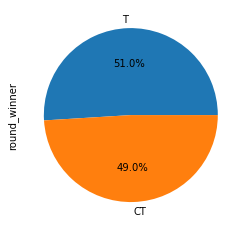

In [21]:
round(round_winner.value_counts()/data.shape[0]*100,2).plot.pie(autopct= '%2.1f%%')

## Eda Bitti

# ENCODING

In [22]:
data.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [23]:
data['bomb_planted'] = data['bomb_planted'].astype(np.int16)

In [24]:
encoder = LabelEncoder()

data['map'] = encoder.fit_transform(data['map'])
map_mappings={index : label for index, label in enumerate(encoder.classes_)}
print(map_mappings)

{0: 'de_cache', 1: 'de_dust2', 2: 'de_inferno', 3: 'de_mirage', 4: 'de_nuke', 5: 'de_overpass', 6: 'de_train', 7: 'de_vertigo'}


In [25]:
data['round_winner'] = encoder.fit_transform(data['round_winner'])
roundwinner_mappings={index : label for index, label in enumerate(encoder.classes_)}
print(roundwinner_mappings)

{0: 'CT', 1: 'T'}


# Remove Duplicates

In [26]:
#checking duplicated row
data.duplicated().sum()
data.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [27]:
data = data.drop_duplicates()

data.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Scaling

In [28]:
column_names = list(data.columns.values)

In [29]:
scaler = StandardScaler()

X = data.drop(['round_winner'], axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)


# Split X and Y

In [30]:
y=data['round_winner']

X.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.509685,-1.409672,-1.413115,-1.303996,-0.363148,0.683520,0.716735,-1.865404,-1.737687,-0.530630,...,-1.076826,-1.051011,-0.910628,-0.911032,-0.701888,-0.139622,-0.214537,-0.829282,-0.16322,-0.154805
1,1.153269,-1.409672,-1.413115,-1.303996,-0.363148,0.683520,0.716735,0.482854,-0.014716,-0.831283,...,-1.076826,-1.051011,-0.910628,0.178864,-0.701888,-0.139622,-0.214537,-0.829282,-0.16322,-0.154805
2,0.025964,-1.409672,-1.413115,-1.303996,-0.363148,-0.130929,0.009485,-0.139434,-0.589039,-0.818019,...,-1.076826,-1.051011,-0.910628,0.178864,-0.701888,-0.139622,-0.214537,-0.829282,-0.16322,-0.154805
3,-0.349805,-1.409672,-1.413115,-1.303996,-0.363148,-0.130929,0.009485,-0.139434,-0.589039,-0.818019,...,-1.076826,-1.051011,-0.910628,-0.911032,-0.701888,-0.139622,-0.214537,-0.829282,-0.16322,-0.154805
4,1.509121,-1.201435,-1.413115,-1.303996,-0.363148,0.683520,0.716735,-0.738240,-1.737687,0.738304,...,-1.076826,-1.051011,-0.910628,-0.911032,-0.701888,-0.139622,-0.214537,-0.829282,-0.16322,-0.154805


# Remove Correlation
Threshold = 0.8

In [31]:
'''corr = pd.DataFrame(X).corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, cmap ='RdYlGn', linewidths = 0.30)'''

"corr = pd.DataFrame(X).corr()\nplt.figure(figsize = (30,30))\nsns.heatmap(corr, cmap ='RdYlGn', linewidths = 0.30)"

In [32]:
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(to_drop)

[12, 14, 15, 89, 93]


In [33]:
for column in to_drop:
    X.drop(labels=column, axis="columns", inplace=True)

# Remove Unnecessary Columns

In [34]:
columns=X.columns

In [35]:
t=[]
for i in columns:
    t.append(X[i].nunique())
    
X[i].nunique()

3

In [36]:
temp =[]
for i in range(len(t)):
    if t[i]==1:
        temp.append(i)
        print(i)

19
27
34
49
55
57


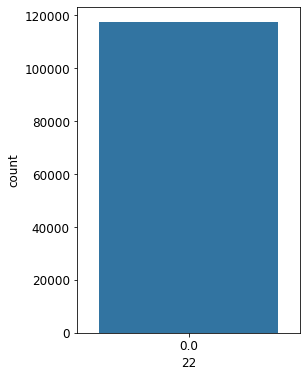

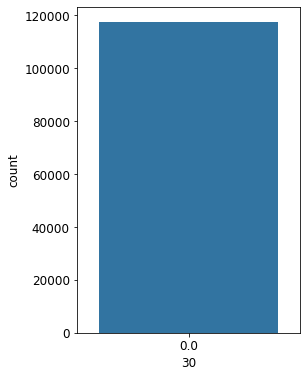

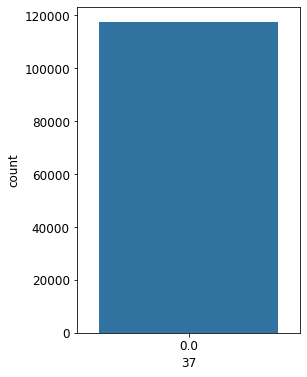

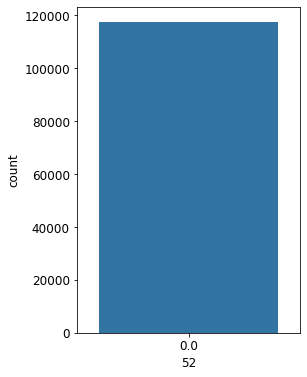

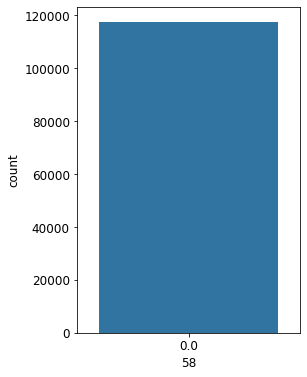

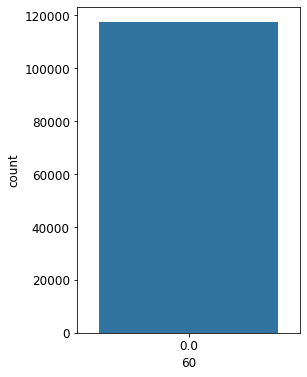

In [37]:
plt.rcParams["figure.figsize"] = (4, 6)
plt.rcParams["font.size"] = 12
for i in temp:
    sns.countplot(X[columns[i]])
    plt.show()

In [38]:
for i in temp:
    X.drop(columns[i], axis = 1, inplace = True)


In [39]:
X

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,90,91,92,94,95
0,1.509685,-1.409672,-1.413115,-1.303996,-0.363148,0.683520,0.716735,-1.865404,-1.737687,-0.530630,...,-0.713585,-0.550042,-1.076826,-1.051011,-0.910628,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
1,1.153269,-1.409672,-1.413115,-1.303996,-0.363148,0.683520,0.716735,0.482854,-0.014716,-0.831283,...,-0.713585,-0.550042,-1.076826,-1.051011,-0.910628,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
2,0.025964,-1.409672,-1.413115,-1.303996,-0.363148,-0.130929,0.009485,-0.139434,-0.589039,-0.818019,...,-0.713585,-0.550042,-1.076826,-1.051011,-0.910628,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
3,-0.349805,-1.409672,-1.413115,-1.303996,-0.363148,-0.130929,0.009485,-0.139434,-0.589039,-0.818019,...,-0.713585,-0.550042,-1.076826,-1.051011,-0.910628,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
4,1.509121,-1.201435,-1.413115,-1.303996,-0.363148,0.683520,0.716735,-0.738240,-1.737687,0.738304,...,-0.713585,-0.550042,-1.076826,-1.051011,-0.910628,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117443,-1.488758,0.880931,1.483980,1.283219,2.753701,-1.558084,-1.107969,-0.720628,0.324135,-0.875497,...,-0.713585,-0.550042,-0.511658,0.058215,-0.335404,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
117444,1.508370,0.880931,1.690915,1.283219,-0.363148,0.683520,0.716735,-1.307692,-0.732620,0.132576,...,-0.713585,-0.550042,-0.511658,0.058215,-0.335404,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805
117445,0.381065,0.880931,1.690915,1.283219,-0.363148,0.683520,0.716735,1.040566,0.990350,-0.778227,...,0.839600,-0.550042,1.183847,1.167441,0.815045,-0.017999,-0.139622,-0.214537,-0.16322,-0.154805
117446,0.005297,0.880931,1.690915,1.283219,-0.363148,0.683520,0.716735,1.040566,0.990350,-0.778227,...,0.839600,-0.550042,-0.511658,1.722054,-0.910628,-0.701888,-0.139622,-0.214537,-0.16322,-0.154805


# PCA

In [40]:
pca = PCA(n_components = 80)
pca.fit(X)

x_pca = pca.transform(X)
summary = sum(pca.explained_variance_ratio_)
print("Variance ratio: ", pca.explained_variance_ratio_)
print("Sum: ", sum(pca.explained_variance_ratio_))

Variance ratio:  [0.08434502 0.04333532 0.03952315 0.03029601 0.02713473 0.02155464
 0.0171108  0.01680129 0.01647663 0.01430573 0.01396294 0.01329016
 0.01299083 0.01272972 0.01261626 0.01238762 0.01238268 0.01227591
 0.01219384 0.01217612 0.01208845 0.01204998 0.01197704 0.01194758
 0.01188968 0.01184685 0.0118225  0.01180449 0.01178499 0.01177902
 0.01177027 0.01176736 0.01174824 0.01172854 0.01172144 0.01165774
 0.0116368  0.01157051 0.01148352 0.01140817 0.01133068 0.01124426
 0.01122407 0.0111418  0.01102173 0.01093062 0.01089149 0.01084462
 0.01074231 0.01066701 0.01040823 0.01038787 0.01028509 0.01020804
 0.01007208 0.01002326 0.00991341 0.00977222 0.00966144 0.00937384
 0.00929418 0.00884265 0.00881904 0.00870707 0.00831067 0.00816468
 0.00781825 0.00760189 0.00727102 0.00655297 0.00565614 0.00521828
 0.00355604 0.00323067 0.00305067 0.00244317 0.00232246 0.00209199
 0.00187374 0.00183872]
Sum:  0.9961809417384365


In [41]:
print("Variance'ın {0:.2f}%".format(summary * 100),"'sini koruyabiliyoruz 80 ile. Biz bunun 95% olmasını istiyoruz.")

Variance'ın 99.62% 'sini koruyabiliyoruz 80 ile. Biz bunun 95% olmasını istiyoruz.


In [42]:
'''
plt.figure(figsize = (10,10))
plt.hist(pca.explained_variance_ratio_, bins = 80)
plt.show()
'''

'\nplt.figure(figsize = (10,10))\nplt.hist(pca.explained_variance_ratio_, bins = 80)\nplt.show()\n'

In [43]:
def getKComponents(pca, alpha):
    total_variance = 0
    
    for feature, variance in enumerate(pca.explained_variance_ratio_):
        total_variance += variance
        if (total_variance >= 1 - alpha):
            return feature + 1
    return len(pca.explained_variance_ratio_)

In [44]:
K = getKComponents(pca, 0.10)
print(K, "Component ile 90% variance'ı koruyoruz.")

62 Component ile 90% variance'ı koruyoruz.


In [45]:
K = getKComponents(pca, 0.05)
print(K, "Component ile 95%'lik variance'ı koruyoruz. Biz 95%'i seçeceğiz.")

68 Component ile 95%'lik variance'ı koruyoruz. Biz 95%'i seçeceğiz.


In [46]:
X = pca.transform(X)[: , : K]

In [47]:
X=pd.DataFrame(X)

In [48]:
X

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-3.081945,-2.547041,-2.228650,1.417889,-0.598456,-1.123216,0.732302,-0.803317,-0.182702,-0.302066,...,0.258220,-0.674225,0.207911,-0.014680,-0.398929,-0.509364,-0.013526,-0.736564,-0.082954,-0.287318
1,-2.033516,-2.000107,-1.326798,1.566379,-0.813405,-1.531728,0.652228,-0.727087,-0.218995,-0.350457,...,0.122309,-0.724863,0.326957,0.005271,-0.402284,-0.594198,0.081235,-0.308651,-0.185656,-0.495688
2,-2.802568,-0.715406,-1.193231,1.216229,-0.813693,-1.471377,0.801615,-0.741728,-0.087765,-0.542456,...,0.300510,-0.639327,0.349048,-0.128560,-0.356599,-0.536895,0.004264,-0.555411,-0.172894,-0.282574
3,-3.157271,-0.537185,-0.483970,1.764575,-0.597280,-0.943086,1.804780,0.794950,-0.819928,-0.381818,...,0.834410,0.235351,1.320463,-1.330428,0.089411,0.081243,0.065630,-0.804834,-0.215324,-0.230017
4,-2.435563,-2.581443,-2.654961,1.273815,-0.180179,-0.802278,0.610695,-0.755642,-0.181354,-0.388229,...,0.075243,-0.437278,-0.054216,0.068872,-0.234159,-0.360065,-0.044377,-0.447045,-0.202132,0.015735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117443,-2.353721,2.199456,1.387166,-2.415185,-1.386813,0.205910,-1.506734,0.910413,-0.433346,-0.885789,...,0.301306,-0.343155,1.147534,-1.079951,0.718118,0.418547,-0.377958,2.060476,0.240034,0.045771
117444,-1.065601,-2.922724,-1.512977,-1.519958,-0.343297,0.184553,-0.772447,1.082693,-0.174762,0.440067,...,-0.121874,0.268276,-0.111832,-0.337272,0.119830,0.536075,0.313368,0.181741,0.741507,-0.114475
117445,1.692068,-0.206382,1.901115,-0.539439,1.417825,0.416888,-1.737142,-0.263688,-0.126820,-0.345745,...,-0.000948,1.015851,0.035888,-0.317211,-0.714225,0.113300,-0.866654,-0.541782,1.436980,-1.893861
117446,0.514772,-0.547590,2.343214,-0.968907,1.605525,0.340758,-2.085403,-0.369175,-0.481850,-0.313475,...,-0.279372,0.803970,-0.206983,-0.283086,-0.780220,-0.039580,-0.810260,-0.190069,1.121238,-1.778204


# Train Test Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [50]:
y_train.isnull().values.any()

False

# TRAINING MODELS

# XGBoost

In [51]:
model1 = XGBClassifier()
model2 = XGBClassifier(n_estimators=100, max_depth=25, learning_rate=0.1)
model3 = XGBClassifier(n_estimators=300, max_depth=40, learning_rate=0.1)
model4 = XGBClassifier(n_estimators=500, max_depth=50, learning_rate=0.1)

In [52]:
train_model1 = model1.fit(X_train, y_train)
train_model2 = model2.fit(X_train, y_train)
train_model3=model3.fit(X_train,y_train)
training_model4  =model4.fit(X_train,y_train)

In [53]:
preds = model1.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 79.63


In [54]:
cr = classification_report(y_test,preds)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79     17172
           1       0.81      0.79      0.80     18063

    accuracy                           0.80     35235
   macro avg       0.80      0.80      0.80     35235
weighted avg       0.80      0.80      0.80     35235



In [55]:
preds = model2.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 84.71


In [56]:
preds = model3.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 85.81


In [57]:
preds = model4.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 85.97


In [58]:
cr = classification_report(y_test,preds)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     17172
           1       0.87      0.85      0.86     18063

    accuracy                           0.86     35235
   macro avg       0.86      0.86      0.86     35235
weighted avg       0.86      0.86      0.86     35235



In [59]:
def cross_val_metrics(model, x_train, y_train) :
    scores = ['accuracy', 'precision', 'recall', 'f1']
    take_score = []
    for sc in scores:
        scores = cross_val_score(model, x_train, y_train, cv = 5, scoring = sc)
        take_score.append(scores.mean())
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))
    return take_score

# Logistic Regression

In [60]:
lr = LogisticRegression()

# Hyperparameter Optimization
parameters = parameters = {
                            'penalty' : ['l2'], 
                            'C'       : np.logspace(-3,3,7),
                            'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
                          }

# Run the grid search
grid_obj = GridSearchCV(lr, parameters, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)


print ('Best Parameters: ', grid_obj.best_params_, ' \n')

Best Parameters:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}  



In [61]:
# Set the lr to the best combination of parameters
lr = grid_obj.best_estimator_

# Train the model using the training sets 
lr.fit(X_train,y_train)

lr_tuning_scores = cross_val_metrics(lr, X_train, y_train)

tuning_lr_test_accuracy = accuracy_score(y_test, lr.predict(X_test))

print("[test accuracy] : %.5f" %tuning_lr_test_accuracy)

[accuracy] : 0.74710 (+/- 0.00434)
[precision] : 0.75256 (+/- 0.00519)
[recall] : 0.75020 (+/- 0.00375)
[f1] : 0.75137 (+/- 0.00394)
[test accuracy] : 0.74463


# Random Forest

In [233]:
rf1 = RandomForestClassifier(random_state = 12345 ,bootstrap = False , criterion = 'gini' , max_depth = 80 , n_estimators=500 )

In [234]:
rf1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, n_estimators=500,
                       random_state=12345)

In [235]:
prediction=rf1.predict(X_test)

In [236]:
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, prediction)))

Model accuracy score with 100 decision-trees : 0.8629


# DEEP NEURAL NETWORK

In [63]:
0.8417
seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(200, input_dim=68, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [64]:
history=model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.4863 - accuracy: 0.4906
Epoch 2/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.3943 - accuracy: 0.4908
Epoch 3/100
8222/8222 [==============================] - 9s 1ms/step - loss: 0.2858 - accuracy: 0.5096
Epoch 4/100
8222/8222 [==============================] - 9s 1ms/step - loss: 0.2498 - accuracy: 0.5918
Epoch 5/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.2364 - accuracy: 0.6724
Epoch 6/100
8222/8222 [==============================] - 9s 1ms/step - loss: 0.2267 - accuracy: 0.6994
Epoch 7/100
8222/8222 [==============================] - 9s 1ms/step - loss: 0.2186 - accuracy: 0.7108
Epoch 8/100
8222/8222 [==============================] - 9s 1ms/step - loss: 0.2116 - accuracy: 0.7167
Epoch 9/100
8222/8222 [==============================] - 9s 1ms/step - loss: 0.2057 - accuracy: 0.7209
Epoch 10/100
8222/8222 [==============================] - 9s 1ms/step 

8222/8222 [==============================] - 10s 1ms/step - loss: 0.1601 - accuracy: 0.7537
Epoch 80/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1599 - accuracy: 0.7543
Epoch 81/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1598 - accuracy: 0.7543
Epoch 82/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1597 - accuracy: 0.7546
Epoch 83/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1595 - accuracy: 0.7548
Epoch 84/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1594 - accuracy: 0.7549
Epoch 85/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1592 - accuracy: 0.7549
Epoch 86/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1591 - accuracy: 0.7553
Epoch 87/100
8222/8222 [==============================] - 10s 1ms/step - loss: 0.1590 - accuracy: 0.7553
Epoch 88/100
8222/8222 [==============================] - 10s 1ms/st

In [65]:
model.evaluate(X_train, y_train)

2570/2570 [==============================] - 3s 988us/step - loss: 0.1574 - accuracy: 0.7569


[0.15739360451698303, 0.7568754553794861]

In [66]:
y_predict = model.predict(X_test)


1102/1102 [==============================] - 1s 972us/step


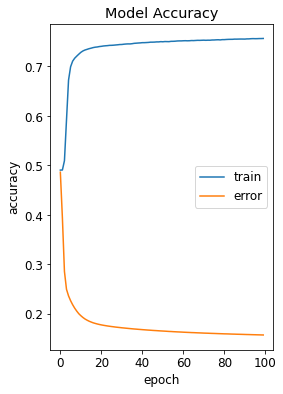

In [67]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'error'])
plt.show()

# TABNET

In [148]:
X_train3=X_train.copy().to_numpy()
X_train4=X_train.copy()
X_test2 = X_test.copy().to_numpy()

In [237]:
clf1_nopreproc = TabNetClassifier( seed = 12345,
                                   optimizer_fn=torch.optim.Adam,
                                   optimizer_params=dict(lr=0.05),
                                   scheduler_params={"step_size":10, "gamma":0.9},
                                   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                   mask_type='entmax',
                                   verbose = 1
                                  )

# fit the model 
clf1_nopreproc.fit( X_train3,y_train,
    eval_set=[(X_train3, y_train)],
    eval_name=['train'],
    eval_metric=['auc','accuracy'],
    max_epochs=300 , patience=50,
    weights=1,
    drop_last=False
)            


epoch 0  | loss: 0.60764 | train_auc: 0.79898 | train_accuracy: 0.71339 |  0:00:06s
epoch 1  | loss: 0.52067 | train_auc: 0.83473 | train_accuracy: 0.73792 |  0:00:13s
epoch 2  | loss: 0.49574 | train_auc: 0.84391 | train_accuracy: 0.74368 |  0:00:19s
epoch 3  | loss: 0.48259 | train_auc: 0.84531 | train_accuracy: 0.7439  |  0:00:26s
epoch 4  | loss: 0.47592 | train_auc: 0.85065 | train_accuracy: 0.75031 |  0:00:32s
epoch 5  | loss: 0.4729  | train_auc: 0.85008 | train_accuracy: 0.74986 |  0:00:39s
epoch 6  | loss: 0.47131 | train_auc: 0.8525  | train_accuracy: 0.75234 |  0:00:45s
epoch 7  | loss: 0.46603 | train_auc: 0.85524 | train_accuracy: 0.75358 |  0:00:52s
epoch 8  | loss: 0.4668  | train_auc: 0.85513 | train_accuracy: 0.7552  |  0:00:58s
epoch 9  | loss: 0.46372 | train_auc: 0.8541  | train_accuracy: 0.75137 |  0:01:04s
epoch 10 | loss: 0.46593 | train_auc: 0.85796 | train_accuracy: 0.75459 |  0:01:10s
epoch 11 | loss: 0.46112 | train_auc: 0.85904 | train_accuracy: 0.75617 |  0

epoch 98 | loss: 0.40995 | train_auc: 0.89659 | train_accuracy: 0.7954  |  0:10:07s
epoch 99 | loss: 0.40743 | train_auc: 0.89735 | train_accuracy: 0.79536 |  0:10:13s
epoch 100| loss: 0.40695 | train_auc: 0.89847 | train_accuracy: 0.79711 |  0:10:19s
epoch 101| loss: 0.4058  | train_auc: 0.89776 | train_accuracy: 0.79597 |  0:10:25s
epoch 102| loss: 0.40404 | train_auc: 0.89733 | train_accuracy: 0.79725 |  0:10:31s
epoch 103| loss: 0.4048  | train_auc: 0.89893 | train_accuracy: 0.79782 |  0:10:37s
epoch 104| loss: 0.40283 | train_auc: 0.89887 | train_accuracy: 0.79754 |  0:10:43s
epoch 105| loss: 0.40585 | train_auc: 0.89752 | train_accuracy: 0.79727 |  0:10:50s
epoch 106| loss: 0.40372 | train_auc: 0.89875 | train_accuracy: 0.79748 |  0:10:56s
epoch 107| loss: 0.4017  | train_auc: 0.90026 | train_accuracy: 0.79965 |  0:11:03s
epoch 108| loss: 0.40146 | train_auc: 0.89765 | train_accuracy: 0.79773 |  0:11:09s
epoch 109| loss: 0.40352 | train_auc: 0.89952 | train_accuracy: 0.79681 |  0

epoch 196| loss: 0.38852 | train_auc: 0.90976 | train_accuracy: 0.81067 |  0:20:13s
epoch 197| loss: 0.3884  | train_auc: 0.91002 | train_accuracy: 0.81064 |  0:20:19s
epoch 198| loss: 0.38698 | train_auc: 0.90987 | train_accuracy: 0.81123 |  0:20:25s
epoch 199| loss: 0.38995 | train_auc: 0.90966 | train_accuracy: 0.81016 |  0:20:31s
epoch 200| loss: 0.38964 | train_auc: 0.90976 | train_accuracy: 0.8102  |  0:20:37s
epoch 201| loss: 0.39001 | train_auc: 0.90965 | train_accuracy: 0.81009 |  0:20:43s
epoch 202| loss: 0.38829 | train_auc: 0.90963 | train_accuracy: 0.81047 |  0:20:49s
epoch 203| loss: 0.39042 | train_auc: 0.91071 | train_accuracy: 0.81258 |  0:20:56s
epoch 204| loss: 0.38712 | train_auc: 0.9105  | train_accuracy: 0.81201 |  0:21:02s
epoch 205| loss: 0.38779 | train_auc: 0.91058 | train_accuracy: 0.81148 |  0:21:08s
epoch 206| loss: 0.38498 | train_auc: 0.91011 | train_accuracy: 0.81043 |  0:21:14s
epoch 207| loss: 0.38447 | train_auc: 0.91022 | train_accuracy: 0.81112 |  0

epoch 294| loss: 0.38105 | train_auc: 0.91428 | train_accuracy: 0.81595 |  0:30:38s
epoch 295| loss: 0.37871 | train_auc: 0.91448 | train_accuracy: 0.81629 |  0:30:44s
epoch 296| loss: 0.38202 | train_auc: 0.91405 | train_accuracy: 0.81543 |  0:30:50s
epoch 297| loss: 0.37997 | train_auc: 0.9141  | train_accuracy: 0.81477 |  0:30:56s
epoch 298| loss: 0.38381 | train_auc: 0.91405 | train_accuracy: 0.8151  |  0:31:02s
epoch 299| loss: 0.38795 | train_auc: 0.91445 | train_accuracy: 0.81581 |  0:31:09s
Stop training because you reached max_epochs = 300 with best_epoch = 286 and best_train_accuracy = 0.81646


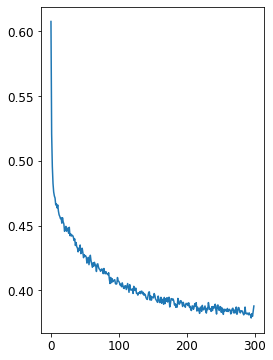

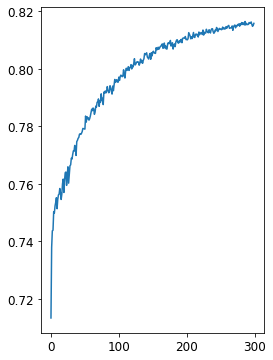

BEST ACCURACY SCORE ON TEST SET : 0.7753937845891868


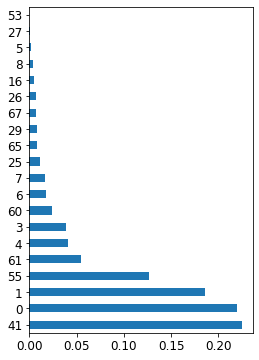

In [239]:
plt.plot(clf1_nopreproc.history['loss'])
plt.show()

# plot accuracy
plt.plot(clf1_nopreproc.history['train_accuracy'])
plt.show()

# find and plot feature importance
feat_importances = pd.Series(clf1_nopreproc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = clf1_nopreproc.predict(X_test2)
test_acc = accuracy_score(preds, y_test)

print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")